# Week 5 plan

- Use energy map to create spectra

- Work on honing in Bragg line detection to get it as accurate as possible, since I think it might be slightly missing the lines at the moment

- If time, look more at identifying and treating double hits.

# Creating spectra

[array([1306, 1444], dtype=int64), array([1279, 1417], dtype=int64), array([1306, 1455], dtype=int64)]
[(10181.388888888889, 900.0, 8902.950518171621), (8644.388412017168, 843.4687339055794, 7229.083295648567)]


(776.8433485789491, 6807.774372630616)

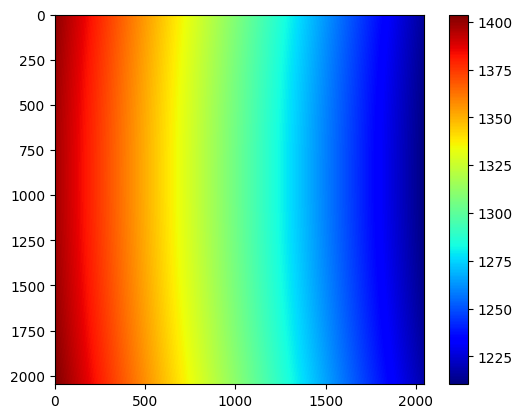

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bragg import locate_bragg_lines, create_energy_map
%matplotlib inline
master_dark = np.load('data/master_dark.npy')
img = np.load('data/images/image8.npy')
img -= master_dark

bragg_lines = locate_bragg_lines(
    img,
    [200,1000,1600],
    200,
    30,
    2,
    100,
    (9,9)
)
print(bragg_lines)
line_energies = [1218.5, 1188.0]
energy_map, centre, k, D = create_energy_map(img.shape, bragg_lines, line_energies)
plt.imshow(energy_map, cmap="jet")
plt.colorbar()
k, D

In [ ]:
from new_spc import get_all_hits_and_locations

primary_threshold = 75
secondary_threshold = 30
n_sigma = 2

values, locations = get_all_hits_and_locations(img, primary_threshold, secondary_threshold, n_sigma)



In [ ]:
from bragg import get_energies
energies = get_energies(locations, centre, k, D)

Warning from make_histogram: number of bins is greater than range of values in histogram


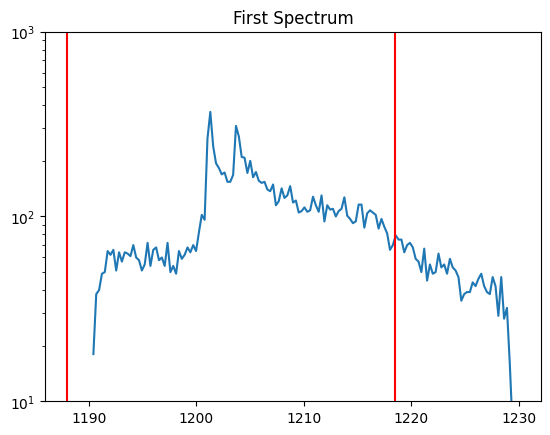

In [ ]:
%matplotlib inline
from histograms import make_histogram

energy_x, energy_y = make_histogram(energies, 150)

plt.plot(energy_x, energy_y)
plt.yscale("log")
plt.ylim(10,1000)
plt.title("First Spectrum")
plt.vlines(line_energies, 0, 1000, colors='r')

In [ ]:
from matplotlib.patches import Circle
%matplotlib qt
fig, ax = plt.subplots()
ax.imshow(img, cmap="jet")
for line in bragg_lines:
    ax.add_patch(Circle((line[0], line[1]), line[2], color='r', fill=False))

plt.show()


# Improving Bragg

## Testing circle locations

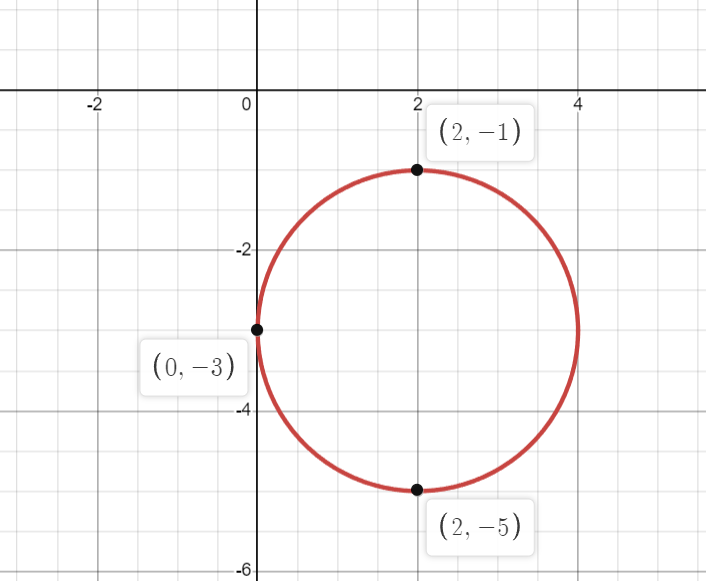

![](images/Screenshot%202024-02-12%20114243.png)


I think we're alright

In [ ]:
from bragg import find_circle
import numpy as np

test_locs = np.array([[2,1], [0,3],[2,5]]).T
find_circle(*test_locs[0], *test_locs[1])

(2.0, 3.0, 2.0)

## Getting more accurate circle centres

Above spectrum shows that the energy calibration is not perfect. Realised that we can determine k and D with 2 equations perfectly, without approximaton (see Mathematica notebook)

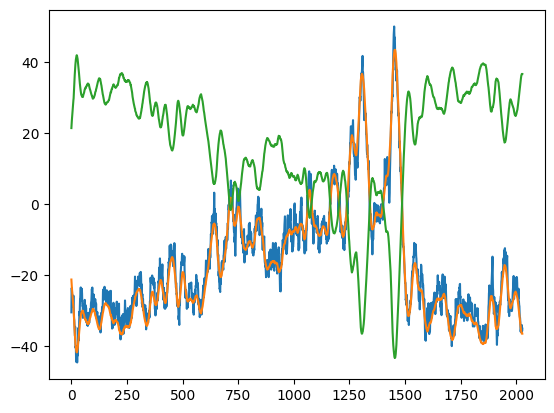

In [ ]:
%matplotlib inline
from bragg import make_lineout, sobel_matrix, convolve_image

raw_lineout = make_lineout(img, 1600, 200, 20)

kernel = sobel_matrix((25,25))

processed_img = convolve_image(img, kernel)

processed_lineout = make_lineout(processed_img, 1600, 200, 20)

neg_processed = convolve_image(img, -kernel)
neg_processed_lineout = make_lineout(neg_processed, 1600, 200, 20)

plt.plot(raw_lineout*50)
plt.plot(processed_lineout)
plt.plot(neg_processed_lineout)

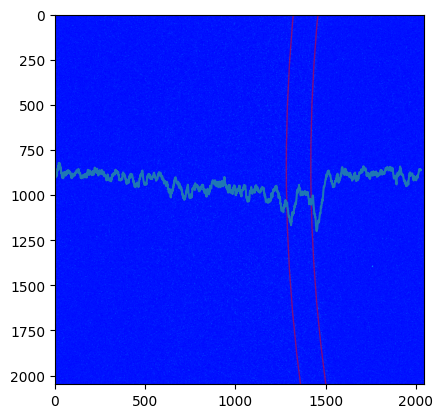

In [ ]:
from bragg import locate_bragg_lines
import matplotlib.patches as patches
%matplotlib inline
bragg_peaks = locate_bragg_lines(img, [200,1000,1800], 200, 20, 2, 100, (25,25))

for bp in bragg_peaks:
    circle = patches.Circle((bp[0], bp[1]), bp[2], fill=False, color='red', alpha=0.5)
    plt.gca().add_patch(circle)

plt.imshow(img, cmap="jet")
plt.plot(raw_lineout*200+1000)

plt.xlim(0,2048)
plt.ylim(2048,0)


plt.show()


The peaks are slightly off, since we are detecting large positive gradients. We should also look for a large negative gradient, and the peak should be in the middle of the negative and positive gradient.

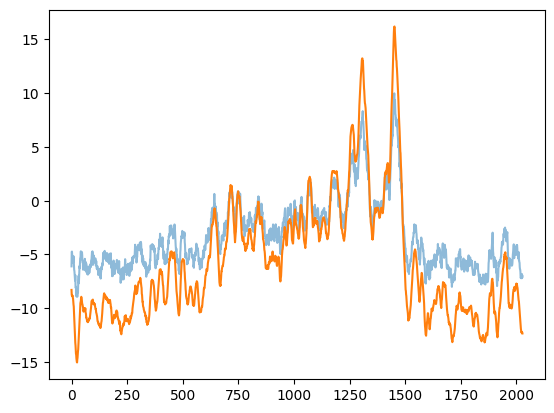

In [ ]:
%matplotlib inline
from bragg import make_lineout, sobel_matrix, convolve_image

raw_lineout = make_lineout(img, 1600, 200, 20)

kernel = sobel_matrix((9,9), True)

processed_img = convolve_image(img, kernel)

processed_lineout = make_lineout(processed_img, 1600, 200, 20)

plt.plot(raw_lineout*10, alpha=0.5)
plt.plot(processed_lineout)
#plt.plot(-neg_processed_lineout)

## Fixing the centre

Although the circles are very closely going through the Bragg lines, they are ending up with vastly differing centres. As such, we should commit to using just one centre from one circle, rather than averaging both.

We can do this by no longer letting k be a free parameter. From theory, $k=nhc/(2d)$.

See written notes, we have $n=1$. Then

$$E=\frac{hc}{2d}\frac{\sqrt{r^2+D^2}}{D^2}$$
$$E=k\frac{\sqrt{r^2+D^2}}{D^2}$$

[array([1306, 1444], dtype=int64), array([1279, 1417], dtype=int64), array([1306, 1455], dtype=int64)]
[(10181.388888888889, 900.0, 8902.950518171621), (8644.388412017168, 843.4687339055794, 7229.083295648567)]


(776.8433485789491, 6807.774372630616)

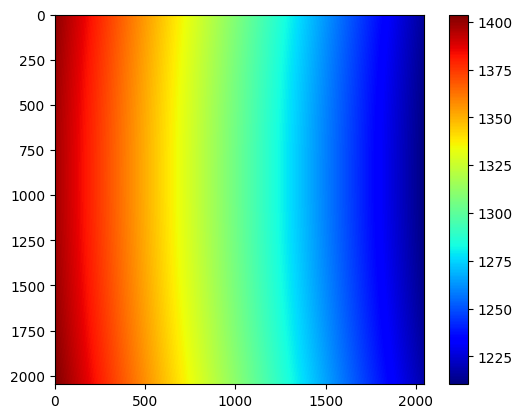

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bragg import locate_bragg_lines, create_energy_map
%matplotlib inline
master_dark = np.load('data/master_dark.npy')
img = np.load('data/images/image8.npy')
img -= master_dark

bragg_lines = locate_bragg_lines(
    img,
    [200,1000,1600],
    200,
    30,
    2,
    100,
    (9,9)
)
print(bragg_lines)
line_energies = [1218.5, 1188.0]
energy_map, centre, k, D = create_energy_map(img.shape, bragg_lines, line_energies)
plt.imshow(energy_map, cmap="jet")
plt.colorbar()
k, D

In [2]:
from new_spc import get_all_hits_and_locations

primary_threshold = 75
secondary_threshold = 30
n_sigma = 2

values, locations = get_all_hits_and_locations(img, primary_threshold, secondary_threshold, n_sigma)

from bragg import get_energies
energies = get_energies(locations, centre, k, D)

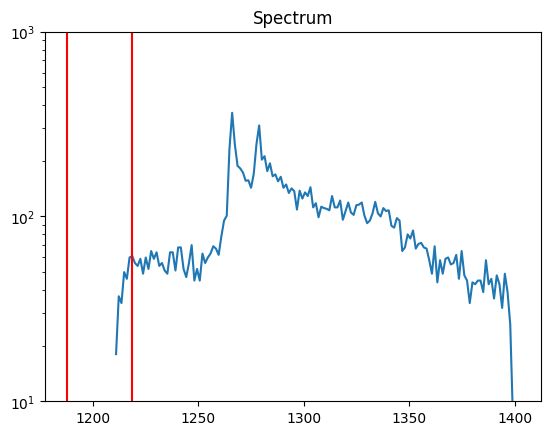

In [3]:
%matplotlib inline
from histograms import make_histogram

energy_x, energy_y = make_histogram(energies, 150)

plt.plot(energy_x, energy_y)
plt.yscale("log")
plt.ylim(10,1000)
plt.title("Spectrum")
plt.vlines(line_energies, 0, 1000, colors='r')

Looks like we're still having problems with the centres. 

Try using more than 3 points on the line to fit several different circles, then use a weighted average to get the average centre and radius of the circles. Weight is 1/(distance of centre from mean).

The problem at the moment is that, although the fits are good, the centre and radius of each circle varies a lot with choice of lineout locations, since a small change in one point can move the circle centre a large amount.

By taking an average, we force there to be only once circle centre, and can determine this as accureatly as possible.

In [4]:
%matplotlib inline
master_dark = np.load('data/master_dark.npy')
img = np.load('data/images/image8.npy')
img -= master_dark

In [58]:
import itertools
from bragg import locate_bragg_lines, create_energy_map

lineout_dy = 200
num_points = 8

point_ys = np.linspace(lineout_dy, img.shape[0]-1-lineout_dy, num_points).astype(int)

y_combinations = list(itertools.combinations(point_ys, 3))

line_params = []

for comb in y_combinations:
    print(comb)
    bragg_lines = locate_bragg_lines(
        img,
        sorted(comb),
        lineout_dy,
        30,
        2,
        100,
        (25,25)
    )
    line_params.append(bragg_lines)

np.array(line_params)

(200, 435, 670)
[array([1306, 1441], dtype=int64), array([1286, 1431], dtype=int64), array([1281, 1422], dtype=int64)]
(200, 435, 905)
[array([1306, 1441], dtype=int64), array([1286, 1431], dtype=int64), array([1277, 1417], dtype=int64)]
(200, 435, 1141)
[array([1306, 1441], dtype=int64), array([1286, 1431], dtype=int64), array([1291, 1422], dtype=int64)]
(200, 435, 1376)
[array([1306, 1441], dtype=int64), array([1286, 1431], dtype=int64), array([1297, 1434], dtype=int64)]
(200, 435, 1611)
[array([1306, 1441], dtype=int64), array([1286, 1431], dtype=int64), array([1306, 1456], dtype=int64)]
(200, 435, 1847)
[array([1306, 1441], dtype=int64), array([1286, 1431], dtype=int64), array([1337, 1479], dtype=int64)]
(200, 670, 905)
[array([1306, 1441], dtype=int64), array([1281, 1422], dtype=int64), array([1277, 1417], dtype=int64)]
(200, 670, 1141)
[array([1306, 1441], dtype=int64), array([1281, 1422], dtype=int64), array([1291, 1422], dtype=int64)]
(200, 670, 1376)
[array([1306, 1441], dtype

array([[[ 5.67465000e+04,  2.67113830e+03,  5.53606797e+04],
        [ 4.98183333e+03,  6.31187943e+02,  3.70103685e+03]],

       [[ 2.90765000e+04,  1.49369149e+03,  2.76657640e+04],
        [ 6.64456452e+03,  7.72696980e+02,  5.36919481e+03]],

       [[ 1.72258377e+04,  9.89407988e+02,  1.58045647e+04],
        [ 6.39909529e+03,  7.51805982e+02,  5.12290050e+03]],

       [[ 1.42906626e+04,  8.64506920e+02,  1.28668333e+04],
        [ 7.37008304e+03,  8.34443238e+02,  6.09718143e+03]],

       [[ 1.24944657e+04,  7.88073008e+02,  1.10690981e+04],
        [ 8.20500000e+03,  9.05500000e+02,  6.93497882e+03]],

       [[ 1.22024602e+04,  7.75647244e+02,  1.07768454e+04],
        [ 8.09375109e+03,  8.96032007e+02,  6.82334415e+03]],

       [[ 1.98531667e+04,  1.17970567e+03,  1.84382132e+04],
        [ 1.10459118e+04,  9.53745307e+02,  9.76903338e+03]],

       [[ 1.30701842e+04,  9.05500000e+02,  1.16505646e+04],
        [ 7.61333824e+03,  7.71161608e+02,  6.33314624e+03]],

       [

((9436.988887671929, 857.9694387165542), 8026.00176121854, 8107.539159668772)

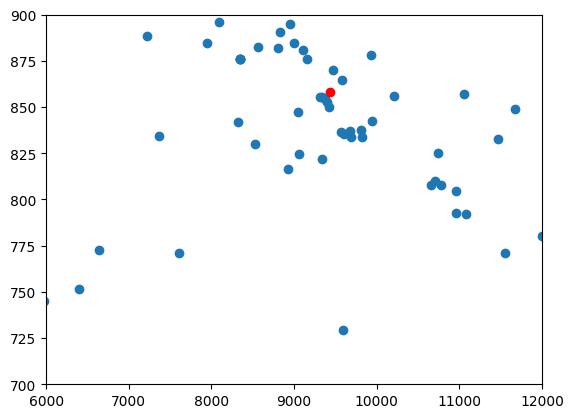

In [59]:
line_params = np.array(line_params)
line_params.shape

plt.scatter(line_params[:, :, 0], line_params[:, :, 1])
plt.xlim(6000,12000)
plt.ylim(700,900)

# take a weighted average of the points, based on how much they differ from the median point
x_locs = line_params[:, :, 0].flatten()
y_locs = line_params[:, :, 1].flatten()

r1s = line_params[:, 0, 2]
r2s = line_params[:, 1, 2]

x_med = np.median(x_locs)
y_med = np.median(y_locs)

weights = 1/((x_locs - x_med)**2 + (y_locs - y_med)**2)

x_avg = np.average(x_locs, weights=weights)
y_avg = np.average(y_locs, weights=weights)

r1 = np.average(r1s, weights=weights[0::2])
r2 = np.average(r2s, weights=weights[1::2])

#r1 = np.average(r1s, weights=1/np.abs(r1s-np.median(r1s)))
#r2 = np.average(r2s, weights=1/np.abs(r2s-np.median(r2s)))



centre = (x_avg, y_avg)

plt.scatter(x_avg, y_avg, color='r')

centre, r1, r2


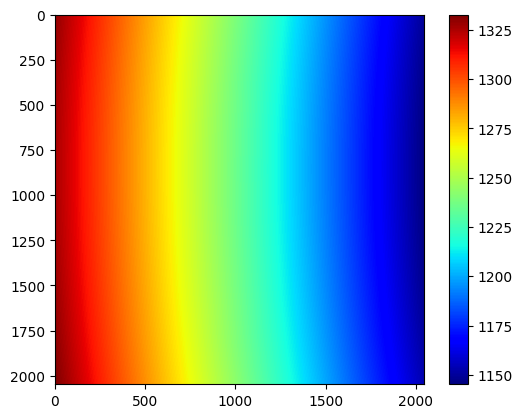

In [60]:
from scipy import constants
def create_energy_map(shape, centre, energies, r1, r2):

    assert (r1<r2 and energies[0] < energies[1]) or (r1>r2 and energies[0] > energies[1])

    two_d = 15.96e-10

    k = constants.h * constants.c / (two_d*constants.e)

    E12 = energies[0] ** 2
    E22 = energies[1] ** 2

    D1 = r1/np.sqrt(E12/(k**2) -1)
    D2 = r2/np.sqrt(E22/(k**2) -1)

    D = (D1 + D2) / 2
    
    indices = np.indices(shape)

    radii = np.sqrt((indices[0] - centre[1])**2 + (indices[1] - centre[0])**2)

    energy_map = (k / D) * np.sqrt(radii**2 + D**2)

    return energy_map, k, D

energy_map, k, D = create_energy_map(img.shape, centre, [1188.0, 1218.5], r1, r2)

plt.imshow(energy_map, cmap="jet")
plt.colorbar()

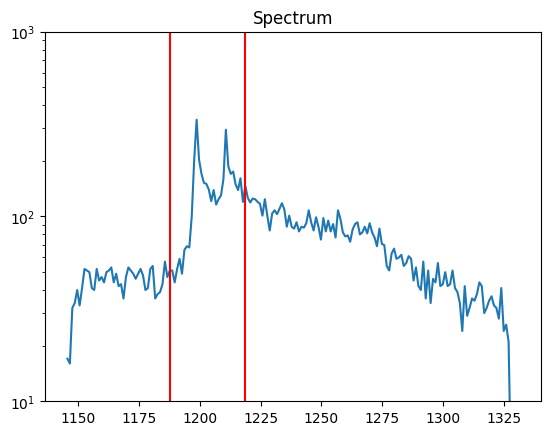

In [61]:
from new_spc import get_all_hits_and_locations
from bragg import get_energies
primary_threshold = 75
secondary_threshold = 30
n_sigma = 2

values, locations = get_all_hits_and_locations(img, primary_threshold, secondary_threshold, n_sigma)

energies = get_energies(locations, centre, k, D)

%matplotlib inline
from histograms import make_histogram

energy_x, energy_y = make_histogram(energies, -1)

plt.plot(energy_x, energy_y)
plt.yscale("log")
plt.ylim(10,1000)
plt.title("Spectrum")
plt.vlines(line_energies, 0, 1000, colors='r')

This is better. To make it perfect, we could do some sort of transformation to the graph to make it perfect.

## Using a hit image instead

In [89]:
from new_spc import get_all_hits_and_locations, create_image_of_hits

primary_threshold = 75
secondary_threshold = 30
n_sigma = 2

values, locations = get_all_hits_and_locations(img, primary_threshold, secondary_threshold, n_sigma)

hit_img = create_image_of_hits(img.shape, values, locations)

lineout_dy = 200
num_points = 6

point_ys = np.linspace(lineout_dy, hit_img.shape[0]-1-lineout_dy, num_points).astype(int)

y_combinations = list(itertools.combinations(point_ys, 3))

line_params = []

for comb in y_combinations:
    bragg_lines = locate_bragg_lines(
        hit_img,
        sorted(comb),
        lineout_dy,
        30,
        2,
        100,
        (15,15)
    )
    line_params.append(bragg_lines)


[array([1308, 1443], dtype=int64), array([1282, 1426], dtype=int64), array([1276, 1416], dtype=int64)]
[array([1308, 1443], dtype=int64), array([1282, 1426], dtype=int64), array([1289, 1424], dtype=int64)]
[array([1308, 1443], dtype=int64), array([1282, 1426], dtype=int64), array([1303, 1448], dtype=int64)]
[array([1308, 1443], dtype=int64), array([1282, 1426], dtype=int64), array([1340, 1480], dtype=int64)]
[array([1308, 1443], dtype=int64), array([1276, 1416], dtype=int64), array([1289, 1424], dtype=int64)]
[array([1308, 1443], dtype=int64), array([1276, 1416], dtype=int64), array([1303, 1448], dtype=int64)]
[array([1308, 1443], dtype=int64), array([1276, 1416], dtype=int64), array([1340, 1480], dtype=int64)]
[array([1308, 1443], dtype=int64), array([1289, 1424], dtype=int64), array([1303, 1448], dtype=int64)]
[array([1308, 1443], dtype=int64), array([1289, 1424], dtype=int64), array([1340, 1480], dtype=int64)]
[array([1308, 1443], dtype=int64), array([1303, 1448], dtype=int64), arra

((8972.145029502124, 851.38965102545), 7585.308232514506, 7497.601173104072)

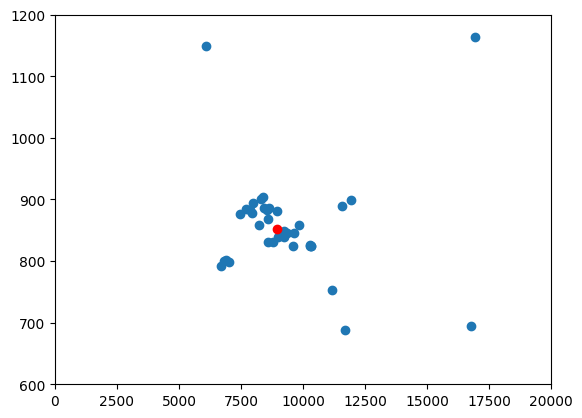

In [92]:
line_params = np.array(line_params)
line_params.shape

plt.scatter(line_params[:, :, 0], line_params[:, :, 1])
#plt.xlim(6000,12000)
#plt.ylim(700,900)

# take a weighted average of the points, based on how much they differ from the median point
x_locs = line_params[:, :, 0].flatten()
y_locs = line_params[:, :, 1].flatten()

r1s = line_params[:, 0, 2]
r2s = line_params[:, 1, 2]

x_med = np.median(x_locs)
y_med = np.median(y_locs)

weights = 1/((x_locs - x_med)**2 + (y_locs - y_med)**2)

x_avg = np.average(x_locs, weights=weights)
y_avg = np.average(y_locs, weights=weights)

r1 = np.average(r1s, weights=weights[0::2])
r2 = np.average(r2s, weights=weights[1::2])

#r1 = np.average(r1s, weights=1/np.abs(r1s-np.median(r1s)))
#r2 = np.average(r2s, weights=1/np.abs(r2s-np.median(r2s)))



centre = (x_avg, y_avg)

plt.scatter(x_avg, y_avg, color='r')
plt.xlim(0,20000)
plt.ylim(600,1200)
centre, r1, r2

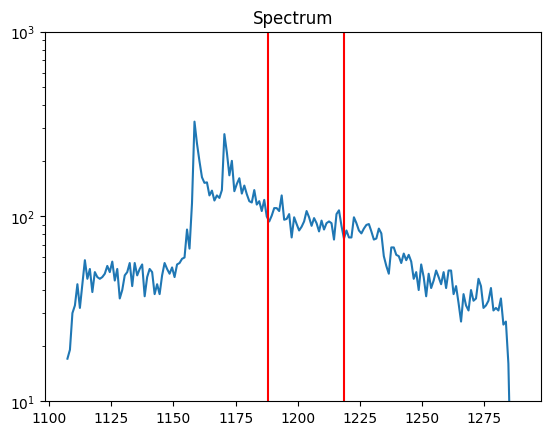

In [93]:
energies = get_energies(locations, centre, k, D)

%matplotlib inline
from histograms import make_histogram

energy_x, energy_y = make_histogram(energies, -1)

plt.plot(energy_x, energy_y)
plt.yscale("log")
plt.ylim(10,1000)
plt.title("Spectrum")
plt.vlines(line_energies, 0, 1000, colors='r')

Not as good as regular images, so will stick to those for now

# SPC Improvements

Things to consider

- Proper consideration of double hits, and discerning between single and double hits
- More accurate determination of hit centres (Gaussian fitting to each hit perhaps)
- Allowed shapes of single hits
    - Once we have determined all the pixels that we think constitute a single hit, we can then check the final shape against a finite number of allowed shapes. 
        - If the shape is one of the allowed shapes, keep it.
        - If not, start by removing any pixels below the secondary threshold until we get an allowed hit. If secondary pixels have to be removed, we may have a double hit.
        



## Considering allowed shapes

Consider the array of neighbours. If it does not match one of the allowed shapes, remove non-thresholded pixels until it does.

If thresholded pixels have to be removed to make it fit, then this is almost certainly a double hit.

Shapes should be considered with brightest pixel at centre

In [5]:
allowed_base_shapes = [
    [[0,0,0],
     [0,1,0],
     [0,0,0]],

    [[0,0,0],
     [0,1,1],
     [0,0,0]],

    [[0,1,0],
     [0,1,1],
     [0,0,0]],

    [[0,1,1],
     [0,1,1],
     [0,0,0]]
]

# rotate the shapes to get all possible orientations
# first shape need not be rotated
allowed_shapes = [np.rot90(shape, k) for shape in allowed_base_shapes[1:] for k in range(4)]
allowed_shapes.append(np.array(allowed_base_shapes[0]))
allowed_shapes = np.array(allowed_shapes, dtype=bool)


Now we need some logic to turn an array of locations into a 3x3 array that we can check against

In [64]:
import numpy as np

class DoubleHitException(Exception):
    pass

def check_pixel_in_bounds(rel_loc, value, secondary_threshold):
    """If a pixel is within the 3x3 matrix, return True.
    If it is outside the matrix, but is below the secondary threshold, return False.
    If it is outside the matrix and above the secondary threshold, raise a
    DoubleHitException."""
    if rel_loc[0] >= 0 and rel_loc[0] < 3 and rel_loc[1] >= 0 and rel_loc[1] < 3:
        return True
    elif value > secondary_threshold:
        raise DoubleHitException
    else:
        return False

def process_neighbours(
    locations: np.ndarray,
    values: np.ndarray,
    secondary_threshold: float,
    allowed_shapes: np.ndarray,
) -> tuple[tuple[float, float], float]:
    """
    Process the neighbours of a hit, and return the location and value of the hit.
    First, remove all pixels that lie outside of a 3x3 centred around the maximum value.
    If any pixel above the secondary threshold is removed, raise a DoubleHitException.

    Then, remove pixels until the 3x3 matrix is one of the allowed shapes.
    If a pixel above the secondary threshold has to be removed, raise a DoubleHitException.
    """


    # descibe all positions relative to the max location, where this location is placed at (1,1)
    max_location = locations[np.argmax(values)]

    relative_locations = locations - max_location + [1, 1]

    # look at all the pixels that lie outside the 3x3 matrix. If they are all below the
    # secondary threshold, then remove them from the list of locations

    # in format [(loc, val), (loc, val), ...]
    valid_locations = [i for i in zip(relative_locations, values) if check_pixel_in_bounds(*i, secondary_threshold)]
    

    # we can now turn this into a 3x3 matrix
    hit_matrix = np.zeros((3, 3))
    for loc, val in valid_locations:
        hit_matrix[loc[0], loc[1]] = val

    # we can now check if this matrix is one of the allowed shapes
    def is_allowed_shape(hit_matrix, allowed_shapes):
        current_shape = hit_matrix > 0
        for shape in allowed_shapes:
            if np.all(current_shape == shape):
                return True
        return False

    # check if the hit matrix is one of the allowed shapes. If it is not, keep removing the
    # pixel with the lowest value until it is. If it is not a valid shape, and there are
    # no pixels below the second threshold, then we have a double hit

    is_allowed = False
    while not is_allowed:
        print(hit_matrix)
        is_allowed = is_allowed_shape(hit_matrix, allowed_shapes)
        if not is_allowed:
            # get the location of the pixel with the lowest value, excluding pixels that are 0
            # a bit of a hack, but it works
            # set all zeros to the maximum value, so that they are not selected
            temp = hit_matrix.copy()
            temp[temp == 0] = np.max(temp)
            # get the location of the minimum value
            min_loc = np.unravel_index(np.argmin(temp), hit_matrix.shape)
            if hit_matrix[*min_loc] > secondary_threshold:
                raise DoubleHitException
            hit_matrix[min_loc] = 0
    
    # if the hit is good, we have reached this point, so return its location and value
    
    return tuple(max_location), np.sum(hit_matrix.flatten())

In [68]:
test_locs = np.array([[2,0], [2,1], [2,2], ])
values = np.array([50,100,50])
secondary_threshold = 25

process_neighbours(test_locs, values, secondary_threshold, allowed_shapes)

[[  0.   0.   0.]
 [ 50. 100.  50.]
 [  0.   0.   0.]]


DoubleHitException: 

Jobs for tomorrow

- Implement this process into get primary and secondary hits
- Think about how we're going to consider secondary hits

### Implementing for primary hits
- For each primary hit, run the checking routine. If it passes, keep it as a single hit. Otherwise, designate it a multiple hit.


# Refactoring to use classes



Baseline test

In [1]:
from new_spc import SPC
from bragg import EnergyMap
from histograms import make_histogram
import numpy as np
import matplotlib.pyplot as plt
img_raw = np.load('data/images/image8.npy')


In [2]:

spc = SPC(img_raw, 75, 30, 2)

hit_values = spc.all_hit_values
hit_locations = spc.all_hit_locations

energy_map = EnergyMap(spc.img, 5, 200, 20, 2, 100, (25,25), [1188.0, 1218.5])


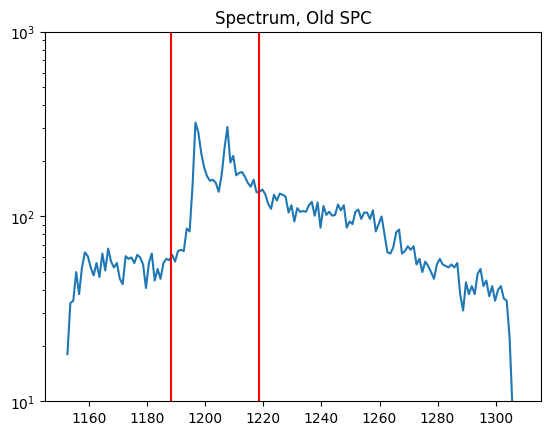

In [3]:
energies = energy_map.get_energies(hit_locations)

bin_centers, hist = make_histogram(energies, -1)

plt.plot(bin_centers, hist)
plt.yscale("log")
plt.ylim(10,1000)
plt.title("Spectrum, Old SPC")
plt.vlines(energy_map.energies, 0, 1000, colors='r')

In [4]:
from new_spc import ShapeCheckingSPC, DoubleHitException

scspc = ShapeCheckingSPC(img_raw, 75, 30, 2)

sc_hit_values = scspc.all_hit_values
sc_hit_locations = scspc.all_hit_locations

sc_energy_map = EnergyMap(scspc.img, 5, 200, 20, 2, 100, (25,25), [1188.0, 1218.5])

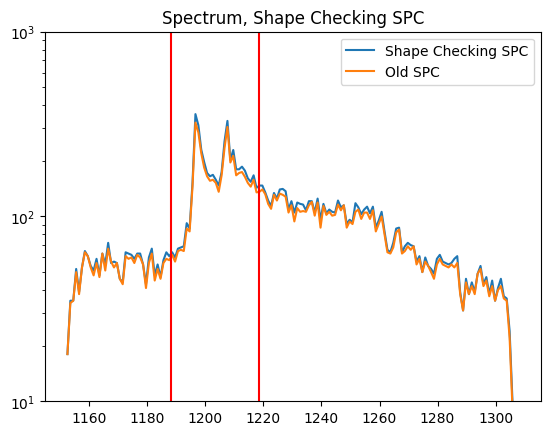

In [14]:
sc_energies = sc_energy_map.get_energies(sc_hit_locations)

sc_bin_centers, sc_hist = make_histogram(sc_energies, -1)

plt.plot(sc_bin_centers, sc_hist, label = "Shape Checking SPC")
plt.plot(bin_centers, hist, label = "Old SPC")
plt.yscale("log")
plt.ylim(10,1000)
plt.title("Spectrum, Shape Checking SPC")
plt.vlines(sc_energy_map.energies, 0, 1000, colors='r')
plt.legend()

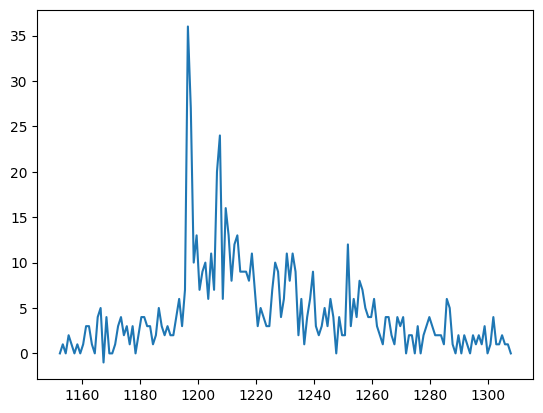

In [15]:
plt.plot(bin_centers, sc_hist-hist)

So, we see that, as expected, there are more double hits in the peaks, and this enhances the peaks, but only slightly. We can see the proportion of double hits:

In [18]:
u, c = np.unique(scspc.all_hit_locations, axis = 0, return_counts=True)
dup = u[c > 1]

n2 = len(dup)
n1 = len(scspc.all_hit_locations)
N = 2048*2048

n1/n2, 2*N/(n1+2*n2)

(20.43465909090909, 531.1262504748639)

This suggests that we are seeing more double hits than expected. However, photon distribution is not uniform, so we should modify our Poisson statistics

### Removing the third threshold

In [4]:
from new_spc import ShapeCheckingSPC, DoubleHitException

# we can remove the lowest threshold by setting it to be very large
scspc = ShapeCheckingSPC(img_raw, 75, 10, 200)

sc_hit_values = scspc.all_hit_values
sc_hit_locations = scspc.all_hit_locations

sc_energy_map = EnergyMap(scspc.img, 5, 200, 20, 2, 100, (25,25), [1188.0, 1218.5])

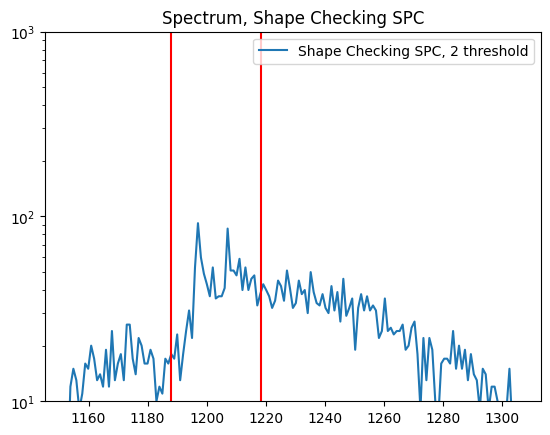

In [5]:
sc_energies = sc_energy_map.get_energies(sc_hit_locations)

sc_bin_centers, sc_hist = make_histogram(sc_energies, -1)

plt.plot(sc_bin_centers, sc_hist, label = "Shape Checking SPC, 2 threshold")
plt.yscale("log")
plt.ylim(10,1000)
plt.title("Spectrum, Shape Checking SPC")
plt.vlines(sc_energy_map.energies, 0, 1000, colors='r')
plt.legend()

Not good - we see fewer hits, so it's noisier.

# Checking other images

Before we move on, it is worth seeing if the code works well for the other images

In [6]:
image_nos = [1, 2, 4, 6, 7, 8, 11, 14, 16, 17, 19] # See Week 3
energies = [1218.5, 1188.0]

images = [np.load(f'data/images/image{no}.npy') for no in image_nos]

from new_spc import ShapeCheckingSPC, DoubleHitException

spcs = [ShapeCheckingSPC(i, 75, 10, 2) for i in images]

hit_values = [spc.all_hit_values for spc in spcs]
hit_locations = [spc.all_hit_locations for spc in spcs]

energy_maps = [EnergyMap(spc.img, 5, 200, 20, 2, 100, (25,25), energies) for spc in spcs]

energies = [em.get_energies(loc) for em, loc in zip(energy_maps, hit_locations)]

bin_centers, hists = [make_histogram(energy, -1) for energy in energies]

for i in range(len(bin_centers)):
    plt.plot(bin_centers[i], hists[i], label = f"Image {image_nos[i]}")

KeyboardInterrupt: 

In [3]:
from new_spc import ShapeCheckingSPC, DoubleHitException
from bragg import EnergyMap
import numpy as np
import matplotlib.pyplot as plt
image_nos = [1, 2, 4, 6, 7, 8, 11, 14, 16, 17, 19] # See Week 3
# some of these hang...
image_nos = [1, 2, 4, 6, 8, 11, 14, 16, 17, 19]
energies = [1218.5, 1188.0]
all_images = np.array([np.load(f'data/images/image{no}.npy') for no in image_nos])

spcs = []
hit_values = []
hit_locations = []
energy_maps = []
energy_spectra = []
    

for i in range(len(all_images)):
    spc = ShapeCheckingSPC(all_images[i], 75, 30, 2)
    spcs.append(spc)
    hit_values.append(spc.all_hit_values)
    hit_locations.append(spc.all_hit_locations)
    energy_maps.append(EnergyMap(spc.img, 5, 200, 20, 2, 100, (25,25), energies))
    energy_spectra.append(energy_maps[i].get_energies(hit_locations[i]))
    print(f"Finished image {image_nos[i]}")


Finished image 1
Finished image 2
Finished image 4


KeyboardInterrupt: 

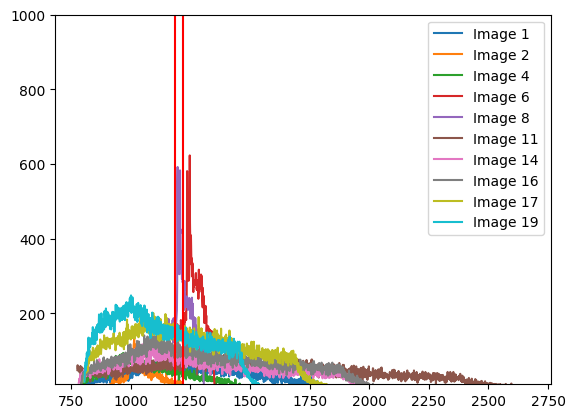

In [17]:
from histograms import make_histogram
for i in range(len(energy_spectra)):
    bin_centers, hist = make_histogram(energy_spectra[i], -1)
    plt.plot(bin_centers, hist, label = f"Image {image_nos[i]}")

plt.ylim(10,1000)
plt.vlines(energies, 0, 1000, colors='r')
plt.legend()


Let's try using the same energy map for all of them

In [2]:
from new_spc import ShapeCheckingSPC
from bragg import EnergyMap
import numpy as np
import matplotlib.pyplot as plt
image_nos = [1, 2, 4, 6, 7, 8, 11, 14, 16, 17, 19] # See Week 3
# some of these hang...
#image_nos = [1, 2, 4, 8, 11, 14, 16, 17, 19]
#image_nos = [11]
energies = [1218.5, 1188.0]
all_images = np.array([np.load(f'data/images/image{no}.npy') for no in image_nos])

spcs = []
hit_values = []
hit_locations = []


for i in range(len(all_images)):
    spc = ShapeCheckingSPC(all_images[i], 75, 30, 2)
    spcs.append(spc)
    hit_values.append(spc.all_hit_values)
    hit_locations.append(spc.all_hit_locations)
    print(f"Finished image {image_nos[i]}")

Finished image 1
Finished image 2
Finished image 4
Finished image 6
Finished image 7
Finished image 8
Finished image 11
Finished image 14
Finished image 16
Finished image 17
Finished image 19


In [6]:
# use image 8 to make the energy map
master_energy_map = EnergyMap(all_images[5], 5, 200, 20, 2, 100, (25,25), energies)

all_hit_energies = [master_energy_map.get_energies(hit_locs) for hit_locs in hit_locations]


Text(0.5, 1.0, 'All spectra')

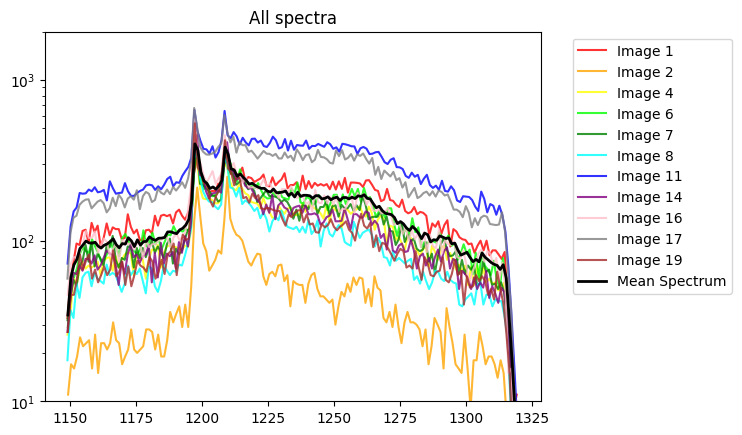

In [12]:
from histograms import make_histogram
colours = ["red", "orange", "yellow", "lime", "green", "cyan", "blue", "purple", "pink", "grey", "brown"]

all_energy_spectra = []


for i in range(len(all_hit_energies)):
    bin_centers, hist = make_histogram(all_hit_energies[i], 150)
    all_energy_spectra.append(hist)
    plt.plot(bin_centers, hist, label = f"Image {image_nos[i]}", c=colours[i], alpha = 0.8)

all_energy_spectra = np.array(all_energy_spectra)
mean_spectrum = np.mean(all_energy_spectra, axis=0)

plt.plot(bin_centers, mean_spectrum, label = "Mean Spectrum", c="black", lw=2)

plt.yscale("log")
plt.ylim(10,2000)
#plt.vlines(energies, 0, 10000, colors='r')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("All spectra")


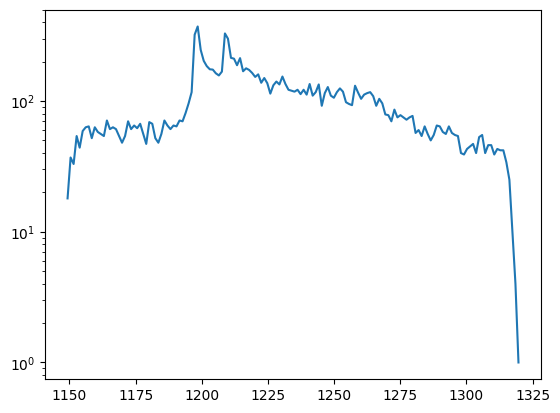

In [14]:
plt.plot(bin_centers, all_energy_spectra[5])
plt.yscale("log")

This is looking really good. May be worth considering that the mean may not be the best one to plot, since the spectra have different average values, so the mean can lead to a more "diluted" spectrum.

Let's try normalising each line by its mean and then summing the results

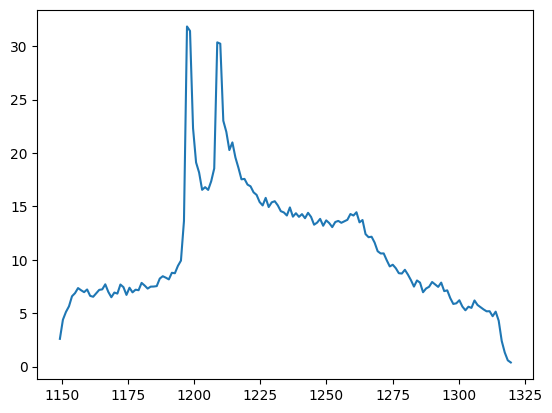

In [11]:
new_sum = np.sum([all_energy_spectra[i]/all_energy_spectra.mean(axis=1)[i] for i in range(len(all_energy_spectra))], axis=0)

plt.plot(bin_centers, new_sum)

To get this better, we need to fix the peak spacing of the X-Ray lines.

# Things to do

- Determining hit locations to sub-pixel precision
    - We can fit a 2D gaussian to each hit, to determine its centre to sub-pixel precision. NB: This only works for single hits
    - This is only worth it if our uncertainity in the energy map is less than the width of a pixel

- Getting uncertainty in energy map
    - There are various sources of uncertainty in the energy mapping that we need to consider:
        - The finite width of the lines in the image
        - Estimation of the circle parameters, and the fact that an average of a large number of circles is taken
        - The fact that the SPC algorithm might pick up noise as hits (although this really shouldn't happen), or more likely, misses hits with larger charge spread
    - These considerations can help guide what needs improving - is SPC the largest source of uncertainty? (probably not). Modt likely, it's the machhinery that creates the energy map.

- Fixing the energy map
    - The x-ray emission lines are still in the wrong place. To get them in the right place, we could perform a linear transform  to the graph. Need to check if this is physically a sensible thing to do.

## Getting beam energies